# Emotion Analysis with Tokenizer and Transformers

Emotion analysis, also known as emotion classification or affective computing, is a Natural Language Processing (NLP) task that aims to identify and classify emotions expressed in text. With the rise of transformer-based models like BERT, emotion detection has become more accurate and context-aware. In this section, we explore how to use a pretrained transformer model along with a tokenizer to perform multi-label emotion classification on text data, enabling machines to better understand the emotional tone behind human language.

| Feature                           | `bert-base-uncased`                         | `roberta-base`                            | `dccuchile/bert-base-spanish-wwm-cased`         |
|-----------------------------------|---------------------------------------------|--------------------------------------------|--------------------------------------------------|
| **Architecture**                  | BERT                                        | RoBERTa (improved BERT)                    | BERT                                             |
| **Casing**                        | Uncased (lowercase only)                    | Cased (case-sensitive)                     | Cased                                            |
| **Language**                      | English                                     | English                                    | Spanish                                          |
| **Model Size**                    | 110 million parameters                      | 125 million parameters                     | 110 million parameters                           |
| **Pretraining Data**              | English Wikipedia + BooksCorpus             | CC-News, OpenWebText, Books, Stories       | Spanish Wikipedia + OPUS + Tatoeba               |
| **Pretraining Data Size (Words)** | ~3.3 billion words                          | ~32 billion words                          | ~2 billion words                                 |
| **Pretraining Data Size (Tokens)**| ~3.3 billion tokens                         | ~300 billion tokens                        | ~2.6 billion tokens                              |
| **Pretraining Data Size (GB)**    | ~16 GB                                      | ~160 GB                                    | ~3 GB                                            |
| **Tokenizer**                     | WordPiece                                   | Byte-Pair Encoding (BPE)                   | WordPiece with Whole Word Masking (WWM)          |
| **Embedding Dimension**           | 768                                         | 768                                        | 768                                              |
| **Number of Layers (Transformers)**| 12                                          | 12                                         | 12                                               |
| **Attention Heads**              | 12                                          | 12                                         | 12                                               |
| **Performance on English**        | Good                                        | Very good                                  | Poor                                             |
| **Performance on Spanish**        | Poor                                        | Medium                                     | Very good                                        |
| **Recommended Use Cases**         | English NLP tasks                           | English NLP tasks (higher performance)     | Spanish NLP tasks (sentiment, classification)    |
| **Hugging Face Model ID**         | `bert-base-uncased`                         | `roberta-base`                             | `dccuchile/bert-base-spanish-wwm-cased`          |

## Import libraries

In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from datasets import Dataset
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Load Data

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [2]:
train_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt", sep=";", header=None, names=['text', 'label'])
val_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt", sep=";", header=None, names=['text', 'label'])
test_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt", sep=";", header=None, names=['text', 'label'])

## Unique tags

In [3]:
# Unique tags
emotion_labels = train_df['label'].unique().tolist()
label2id = {label: idx for idx, label in enumerate(emotion_labels)}
id2label = {v: k for k, v in label2id.items()}

print("Number of emotions:", len(emotion_labels))
print("Labels:", emotion_labels)

# Convert tag to number
train_df['label_id'] = train_df['label'].map(label2id)
val_df['label_id'] = val_df['label'].map(label2id)
test_df['label_id'] = test_df['label'].map(label2id)

Number of emotions: 6
Labels: ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']


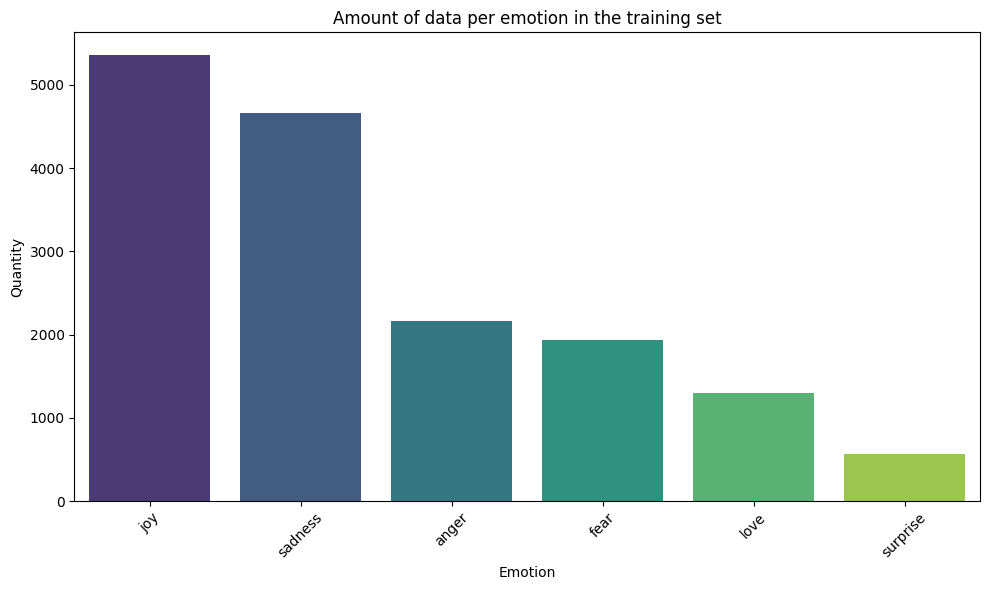

Total rows in the training set: 16000
Total rows in the validation set: 2000
Total rows in the test set: 2000
Total rows in the entire dataset: 20000


In [4]:
emotion_counts = train_df['label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title("Amount of data per emotion in the training set")
plt.xlabel("Emotion")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Total rows in the training set:", len(train_df))
print("Total rows in the validation set:", len(val_df))
print("Total rows in the test set:", len(test_df))
print("Total rows in the entire dataset:", len(train_df) + len(val_df) + len(test_df))

## Tokenization

In [10]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

train_ds = train_ds.rename_column("label_id", "labels")
val_ds = val_ds.rename_column("label_id", "labels")

train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

class BertForSimpleClassification(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSimpleClassification(num_labels=len(emotion_labels)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Train")
losses = []
val_losses = []
# Training loop
for epoch in range(3):
    print("Starting Epoch", epoch)
    model.train()
    total_loss = 0
    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")
    losses.append(total_loss / len(train_loader))
    # Evaluation
    model.eval()
    val_loss = 0
    preds, true_labels = [], []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader, desc="Validating")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels) 
            val_loss += loss.item()

            pred_labels = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred_labels)
            true_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    f1 = f1_score(true_labels, preds, average='macro')
    acc = accuracy_score(true_labels, preds)
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation F1-score: {f1:.4f}, Accuracy: {acc:.4f}")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train
Starting Epoch 0


Training: 100%|██████████| 250/250 [05:27<00:00,  1.31s/it]


Epoch 1: Loss = 0.7883


Validating: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Validation Loss: 0.2309
Validation F1-score: 0.8998, Accuracy: 0.9235
Starting Epoch 1


Training: 100%|██████████| 250/250 [05:26<00:00,  1.31s/it]


Epoch 2: Loss = 0.1808


Validating: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Validation Loss: 0.1598
Validation F1-score: 0.9114, Accuracy: 0.9365
Starting Epoch 2


Training: 100%|██████████| 250/250 [05:25<00:00,  1.30s/it]


Epoch 3: Loss = 0.1206


Validating: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

Validation Loss: 0.1677
Validation F1-score: 0.9098, Accuracy: 0.9330


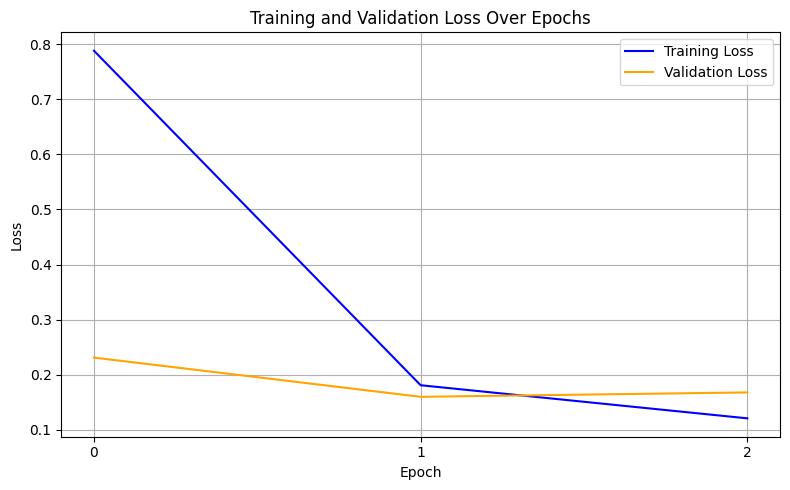

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(losses, label='Training Loss', color='blue')

plt.plot(val_losses, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.xticks(range(len(losses)))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Final Validation F1-score: 0.9098, Accuracy: 0.9330


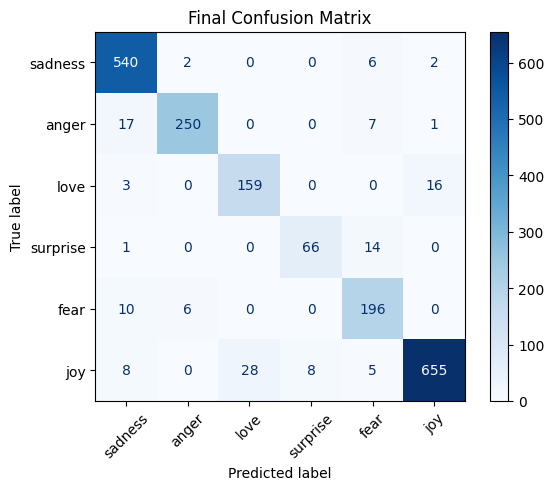

In [13]:
model.eval()
preds, true_labels = [], []
with torch.no_grad():
    for i, batch in enumerate(tqdm(val_loader, desc="Evaluating")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels = torch.argmax(logits, dim=1).cpu().numpy()

        preds.extend(pred_labels)
        true_labels.extend(labels.cpu().numpy())

# Final Metrics
f1 = f1_score(true_labels, preds, average='macro')
acc = accuracy_score(true_labels, preds)
print(f"Final Validation F1-score: {f1:.4f}, Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Final Confusion Matrix")
plt.show()

## Test the model

In [14]:
def predict_text(text, model, tokenizer, device, id2label):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=128)
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_label_id = torch.argmax(logits, dim=1).item()
        pred_label = id2label[pred_label_id]
    
    return pred_label

example_text = "I am so happy to be in class today."
predicted_emotion = predict_text(example_text, model, tokenizer, device, id2label)
print(f"Text: {example_text}")
print(f"Predicted Emotion: {predicted_emotion}")

Text: I am so happy to be in class today.
Predicted Emotion: joy


## #1 Activity - It's your turn

1. **Test the model with 5 original phrases in English. What are your conclusions?**

2. **What happens if you increase the number of epochs during training?**

3. **Test the tokenizer `"roberta-base"`. Are there any differences compared to BERT's tokenizer?**

4. **What effect does changing the dropout probability have on the model's performance?**

5. **What happens if you increase or decrease the learning rate?**

6. **Test the following phrases. What were the results? What conclusions can you draw?**

   - I smiled, but inside, everything was unraveling.  
   - It’s funny how silence can be louder than screams.  
   - He said he was proud, but I saw the disappointment in his eyes.  
   - I don’t miss them, I miss who I thought they were.  
   - She laughed like nothing mattered, though everything did.  
   - I’m not angry, just tired of always pretending I’m okay.  
   - Hope is the cruelest of all lies.  
   - Every time I get close to happiness, I sabotage it myself.  
   - They say time heals, but I think it just teaches you how to hide the pain better.  
   - He was the calm before every storm I never saw coming.

## BERT, Are you ready to analysis data in another language? BETO VS BERT - The great fight


In the realm of natural language processing, BETO and BERT clashed in an epic battle. BERT, the master of English, unleashed its power to understand complex contexts, while BETO, the champion of Spanish, showcased its skill in capturing the subtle nuances and emotions of its language. Though rivals, they soon realized that their true strength lay in complementing each other, joining forces to advance toward a future where all languages are understood with precision.

## Load Data
https://www.kaggle.com/datasets/philipsanm/sentiment-analysis-in-spanish-tweets

In [15]:
# load dataset
df = pd.read_csv("/kaggle/input/sentiment-analysis-in-spanish-tweets/sentiment_analysis_dataset.csv")

print(set(df['sentiment']))
# map tags from text to number
label2id = {label: idx for idx, label in enumerate(df['sentiment'].unique())}
id2label = {v: k for k, v in label2id.items()}
df['label_id'] = df['sentiment'].map(label2id)

# Create Split train/valiidation (80% train, 20% val)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_id'], random_state=42)

{'sad', 'joyful', 'scared', 'peaceful', 'mad', 'powerful'}


## Emotions Distribution

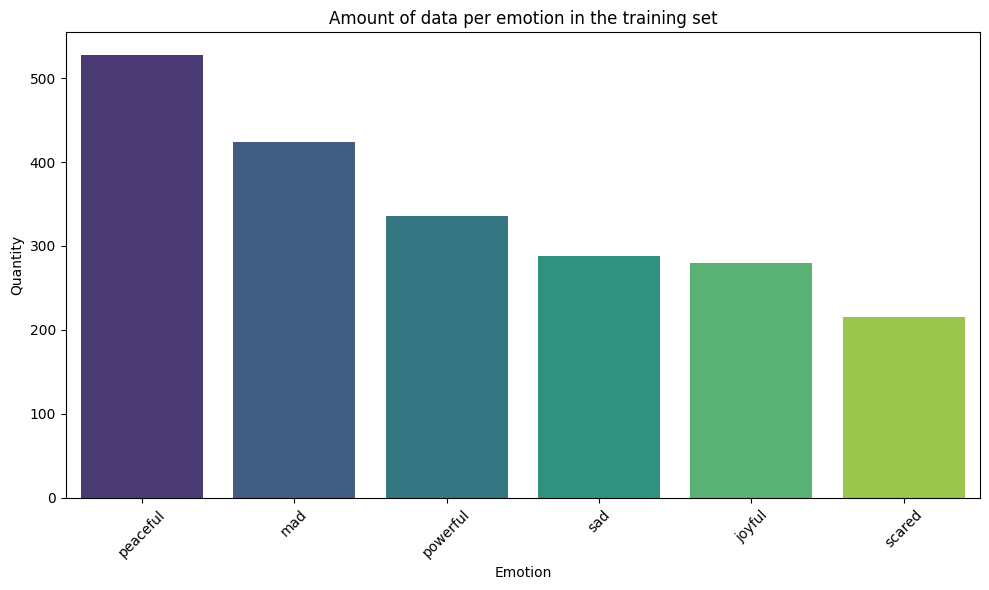

Total rows in the training set: 2072
Total rows in the validation set: 518
Total rows in the entire dataset: 2590


In [16]:
emotion_counts = train_df['sentiment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title("Amount of data per emotion in the training set")
plt.xlabel("Emotion")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Total rows in the training set:", len(train_df))
print("Total rows in the validation set:", len(val_df))
print("Total rows in the entire dataset:", len(train_df) + len(val_df))

## Model Implementation

In [17]:
# Tokenizer BETO
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

train_ds = train_ds.rename_column("label_id", "labels")
val_ds = val_ds.rename_column("label_id", "labels")

train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

class BertForSimpleClassification(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSimpleClassification(num_labels=len(label2id)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Train")
losses = []
val_losses = []
# Training loop
for epoch in range(3):
    print("Starting Epoch", epoch)
    model.train()
    total_loss = 0
    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")
    losses.append(total_loss / len(train_loader))
    # Evaluation
    model.eval()
    val_loss = 0
    preds, true_labels = [], []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader, desc="Validating")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels) 
            val_loss += loss.item()

            pred_labels = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred_labels)
            true_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    f1 = f1_score(true_labels, preds, average='macro')
    acc = accuracy_score(true_labels, preds)
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation F1-score: {f1:.4f}, Accuracy: {acc:.4f}")


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/2072 [00:00<?, ? examples/s]

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train
Starting Epoch 0


Training:   0%|          | 0/33 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training: 100%|██████████| 33/33 [00:44<00:00,  1.34s/it]


Epoch 1: Loss = 1.7493


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Validation Loss: 1.6845
Validation F1-score: 0.1455, Accuracy: 0.2896
Starting Epoch 1


Training: 100%|██████████| 33/33 [00:41<00:00,  1.27s/it]


Epoch 2: Loss = 1.5621


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Validation Loss: 1.4865
Validation F1-score: 0.2968, Accuracy: 0.4112
Starting Epoch 2


Training: 100%|██████████| 33/33 [00:43<00:00,  1.31s/it]


Epoch 3: Loss = 1.1760


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

Validation Loss: 1.1233
Validation F1-score: 0.5691, Accuracy: 0.6081


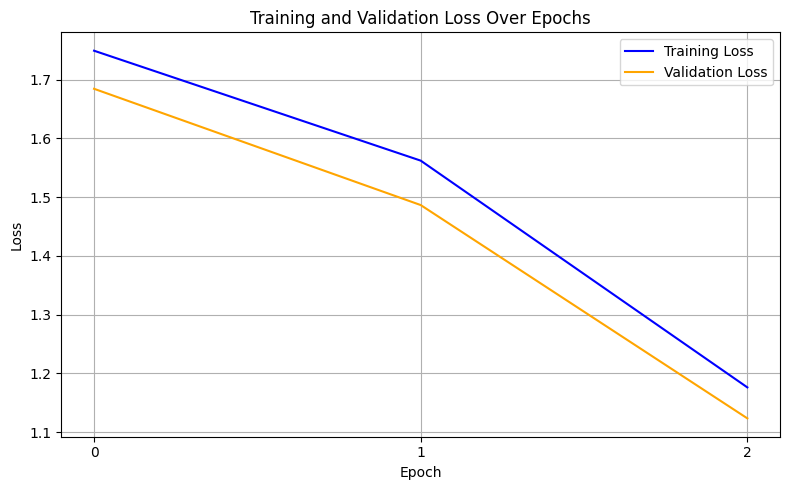

In [18]:
plt.figure(figsize=(8, 5))

plt.plot(losses, label='Training Loss', color='blue')

plt.plot(val_losses, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.xticks(range(len(losses)))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Final F1-score: 0.5691, Accuracy: 0.6081


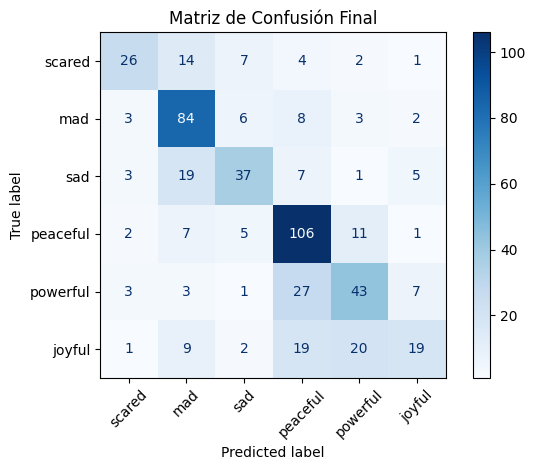

In [19]:
# Final evaluation
model.eval()
preds, true_labels = [], []
with torch.no_grad():
    for i, batch in enumerate(tqdm(val_loader, desc="Evaluating")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels = torch.argmax(logits, dim=1).cpu().numpy()

        preds.extend(pred_labels)
        true_labels.extend(labels.cpu().numpy())

# Final metrics
f1 = f1_score(true_labels, preds, average='macro')
acc = accuracy_score(true_labels, preds)
print(f"Final F1-score: {f1:.4f}, Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión Final")
plt.tight_layout()
plt.show()


## Test the model

In [20]:
test_texts = [
    "Estoy muy feliz con los resultados.",
    "No puedo creer lo triste que me siento hoy.",
    "Me siento frustrado y enojado por lo que pasó.",
    "Qué sorpresa tan agradable recibir esa noticia.",
    "Tengo miedo de lo que pueda pasar mañana.",
    "Me siento íncreible, perdí todos los parciales"
]

inputs = tokenizer(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Eliminar token_type_ids si está presente
inputs.pop("token_type_ids", None)

inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    logits = model(**inputs)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

pred_labels = [id2label[i.item()] for i in preds]

for text, label in zip(test_texts, pred_labels):
    print(f"Text: {text}\nPredicted Sentiment: {label}\n")

Text: Estoy muy feliz con los resultados.
Predicted Sentiment: powerful

Text: No puedo creer lo triste que me siento hoy.
Predicted Sentiment: scared

Text: Me siento frustrado y enojado por lo que pasó.
Predicted Sentiment: mad

Text: Qué sorpresa tan agradable recibir esa noticia.
Predicted Sentiment: powerful

Text: Tengo miedo de lo que pueda pasar mañana.
Predicted Sentiment: scared

Text: Me siento íncreible, perdí todos los parciales
Predicted Sentiment: peaceful



## #2 Activity - It's your turn

1. **Test the model BETO and BERT with 5 original phrases in Spanish. What are your conclusions? What are the differences between these models**

2. **What happens if you increase the number of epochs during training?**

3. **The robustness of datasets (English/Spanish) could it affect the performance of the model? Argument in this specific case emotion-dataset-for-nlp vs sentiment-analysis-in-spanish-tweets (and BETO vs BERT)**

4. **Test the following phrases in Spanish using BETO and BERT. What were the results? What conclusions can you draw?**

   - ¡Qué buena idea, seguro que eso funcionará... no!  
    - Claro, porque todo en la vida es tan fácil como tú lo dices.  
    - Me encanta cuando me ignoras, es como hablar con la pared.  
    - No te preocupes, tus consejos siempre son súper útiles.  
    - ¡Genial! Otra reunión que podría haber sido un email.  
    - Gracias por aclararlo, porque estaba completamente perdido (modo sarcasmo ON).  
    - Seguro que a todos les importa tu opinión, sí, claro.  
    - ¡Qué sorpresa verte llegar tarde, nunca lo haces!  
    - Me alegra que tus problemas sean más importantes que los míos.  
    - No hay nada mejor que trabajar un domingo, dijo nadie jamás.  
